In [1]:
%load_ext autoreload
%autoreload 2

## Importing Libraries and Adjusting Settings

In [2]:
# import modules for eda and plotting
import pandas as pd
import numpy as np

import os
import sys
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from src import functions as fn
from src import visualize as vz

# setting plots to inline
%matplotlib inline

# setting the max number of rows displayed
pd.options.display.max_rows = 300

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='winter_r')

# King County Prices Project

## Introduction

#### Business Problem
A client in King County, WA wants to advise homeowners on home improvement projects that will add to the sale value of their homes, based on data from the most recent full calendar year, 2019.

#### Background Information on the Data
Analysis will be based on the King County House Sales dataset from the King County Department of Assessments. The data was presented as three raw csv files of property data and a fourth with information about the various administrative codes used in the other three: 

* Real Property Sales (EXTR_RPSale.csv)
* Residential Building (EXTR_ResBldg.csv)
* Parcel (EXTR_Parcel.csv)
* Lookup Codes (EXTR_LookUp.csv)


#### Initial EDA Work
Using `sqlite3`, the three raw data files were joined into a single pandas data frame, and the fourth lookup file was read into its own additional data frame. After performing light data cleaning and converting the datatypes of several columns, rows that contained `SalePrice` values of 0 were dropped along columns deemed extraneous to the project. Finally, non-2019 data was dropped and a project data frame of 16,323 rows was created. Full details of this work can be found here in the [EDA Notebook](../exploratory/final_notebook.ipynb).

#### Methods Used For Analysis 
A linear regression model was developed to gain insight into the factors correlated with home prices. That insight, paired with various statistical techniques such as t-tests, was used to develop home improvement recommendations for the client. All statistical tests performed during the project used a significance level of **alpha = .05**, and are detailed in the [EDA Notebook](../exploratory/final_notebook.ipynb).

## Baseline Model
Continuous features in the data were analyzed and the most highly correlated (correlation coefficient = .61) feature, `SqFtTotLiving`, was included in the first simple linear regression model.

In [3]:
data_path1 = os.path.join(gparent,'data/processed','baseline_data.csv')
df = pd.read_csv(data_path1)

#### Data Frame

In [4]:
fsm_df = df[['SalePrice', 'SqFtTotLiving']].copy()

#### Model

In [5]:
fsm = ols(formula="SalePrice ~ SqFtTotLiving", data=fsm_df)
fsm_results = fsm.fit()

## Model Results: R-Squared = .371

In [6]:
fsm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     9644.
Date:                Mon, 08 Mar 2021   Prob (F-statistic):               0.00
Time:                        12:44:42   Log-Likelihood:            -2.3609e+05
No. Observations:               16323   AIC:                         4.722e+05
Df Residuals:                   16321   BIC:                         4.722e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.239e+04   8798.112     -1.408      0.159   -2.96e+04    4857.279
SqFtTotLiving   378.4219      3.853     98.206      0.000     370.869     385.975
==============================================================================
Omnibus:                    21907.178   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13486307.854
Skew:                           7.274   Prob(JB):                         0.00
Kurtosis:                     143.063   Cond. No.                     5.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interpretation of Results
Our coefficient indicates that for every square foot increase in `SqFtTotLiving`, `SalePrice` will increase by \$378.42.

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [7]:
fn.rainbow(fsm_results)

Rainbow statistic: 0.859061271344214
Rainbow p-value: 0.999999999996513


#### Result: Pass

Since the p-value was greater than .05, we fail to reject the null hypothesis and conclude that the model is linearly predicted by the feature. 

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value of 0.00 indicates that the residuals are not normally distributed and that the model violates an assumption of linear regression.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the predictors.

### Error Plot

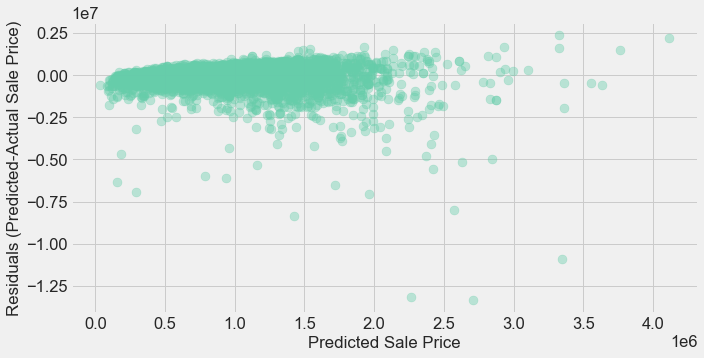

In [8]:
vz.error_plot(fsm_df, 'SalePrice', fsm_results)

#### Result: Fail

We can see from the quantity of dots well below zero, there are more extreme under-prediction than over-predictions. Further, it appears that the over-predictions increase as the predicted price increases.

### Bruesch-Pagan Test

In [9]:
fn.bp_test(fsm_df, 'SalePrice', fsm_results)

Lagrange Multiplier p-value: nan
F-statistic p-value: 1.2835676028594985e-74


#### Result: Fail
The p-value of 0 indicates that we must reject the null hypothesis and conclude that the variance of the target is not homogeneous across values of the predictor. This result is in line the plot of the residuals.

### Independence Check:  Variance Inflation Factor

#### Result: N/A
The model only has one predictor, so it is by independent by definition.

## Bottom Line on the Results of the Baseline Model

While the coefficient of determination is decent at .37, it appears that there are some problems with the intercept. The p-value of .15, which is above our alpha of .05, means that the value is not statisitically significant, and the confidence interval problematic. The condition number of the model is also large, indicating there may be some numerical problems with the data. Although the results of the rainbow test indicate that the target is linearly predicted by the feature and is in line with that assumption of linear regression, there are several problems with the residuals of the model. The p-value for the Jarque_bera test says the residuals and not normally distributed, and the error plot and Bruesch-Pagan test show that they exhibit extreme hetroscadasticity, breaking two of the assumptions of linear regression.

## Intermediate Models & EDA
Details on the intermediate models and EDA can be found in the [EDA Notebook](../exploratory/final_notebook.ipynb).
#### Outliers:
After running the baseline model, a closer look was taken at the target and predictor. Outliers were found (mainly extremely high priced homes) in the `SalePrice` target and removed using the IQR fences method. Running the the model on the cleaned data improved the model by clearing up the problems with the intercept and helping with the residuals, but it lowered the coefficient of determination from .371 to .293. 

As the modeling process progressed, a price-per-square-foot feature was created and employed to find another set of ouliers (mainly homes with a very high price-per-square-foot values) in the data. These were also removed using the IQR fences method. This step resulted in a sizable increase in the coefficient of determination up to .343. 

Lastly, a closer look was taken at the residuals by adding `y_hat` (predicted price) and `residual` (actual price - predicted price) features to the data frame and filtering the data by residuals. A subset of outliers (a group that had a mean sale price almost \$470,000 higher than the the dataset as a whole) that had large under-predictions were identified and removed, which again incresed the r-squared term to .378. Further analysis is needed to fully understand the characteristics of the homes in this subgroup and how they affect the model.

#### Transformations
Log-transforming the target and various predictors was attempted to varying degrees of success; However, better results were found by square-root scaling `SqFtTotLiving` predictor and leaving the other data un-scaled. 

#### Features
Features that could be the subjects of home improvement project were the focus during the modeling process with an eye toward developing actionable recommendations.

## Final Model
The final model was implemented using a forward selection method and was run on a data set of 12,980 rows that had been filtered by residuals.

#### Data Frame

In [10]:
data_path2 = os.path.join(gparent,'data/processed','final_model.csv')
final = pd.read_csv(data_path2)

#### Model

In [11]:
final_results = fn.forward_selected(final, 'SalePrice')

#### Model Results: R-Squared = .375

In [12]:
final_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     863.4
Date:                Mon, 08 Mar 2021   Prob (F-statistic):               0.00
Time:                        12:44:44   Log-Likelihood:            -1.7461e+05
No. Observations:               12980   AIC:                         3.492e+05
Df Residuals:                   12970   BIC:                         3.493e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -5.746e+04   8197.478     -7.010      0.000   -7.35e+04   -4.14e+04
SqFtTotLiving_sqrt  1.462e+04    194.737     75.094      0.000    1.42e+04     1.5e+04
SqFtDeck              71.7399      7.669      9.354      0.000      56.707      86.773
x0_Radiant          1.335e+05   1.44e+04      9.258      0.000    1.05e+05    1.62e+05
x0_Hot_Water        1.006e+05    1.1e+04      9.159      0.000    7.91e+04    1.22e+05
x0_Gravity           2.05e+05   2.94e+04      6.979      0.000    1.47e+05    2.63e+05
x0_Heat_Pump        2.804e+04   6038.259      4.644      0.000    1.62e+04    3.99e+04
SqFtOpenPorch         62.8705     15.639      4.020      0.000      32.216      93.525
x0_Floor_Wall       1.315e+04   8382.866      1.569      0.117   -3276.880    2.96e+04
SqFtEnclosedPorch     57.0904     42.935      1.330      0.184     -27.069     141.250
==============================================================================
Omnibus:                       89.319   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.041
Skew:                          -0.043   Prob(JB):                     2.05e-14
Kurtosis:                       2.669   Cond. No.                     4.83e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
final_results.params

Intercept             -57462.573818
SqFtTotLiving_sqrt     14623.636562
SqFtDeck                  71.739906
x0_Radiant            133542.115362
x0_Hot_Water          100626.054299
x0_Gravity            204966.504146
x0_Heat_Pump           28044.528588
SqFtOpenPorch             62.870475
x0_Floor_Wall          13154.769756
SqFtEnclosedPorch         57.090414
dtype: float64

#### Interpreting the Results
The `SqFtFinBasement`, `Other` and `NA` features were dropped in the forward selection process and not included in the model. The `ElecBB` (Electric Baseboard) heating system category was dropped during encoding and incorporated into the intercept. Since the intercept is smaller than all of the other heating system coefficients, homes with any other type of heating system will have higher sale prices (determined by the various heat type coefficients) relative to homes with `ElecBB` heating when holding all other features constant. Also, when holding all other features constant, the coefficient for `SqFtTotLiving_sqrt` indicates that every one foot increase in living space will result in a \$14,600 increase in `SalePrice`. Further, a one square-foot increase in each of the other continuous SqFt features will slightly increase (by the various coefficients) `SalePrice` when holding all other features constant.

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [14]:
fn.rainbow(final_results)

Rainbow statistic: 0.9910174390849651
Rainbow p-value: 0.6418121563346457


#### Results: Pass
Since the p-value is above .05, we fail to reject the null hypothesis and conclude that the model is linearly predicted by the features.

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value close to 0.00 indicates that the residuals are not normally distributed and that the model violates an assumption of linear regression.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the predictors.

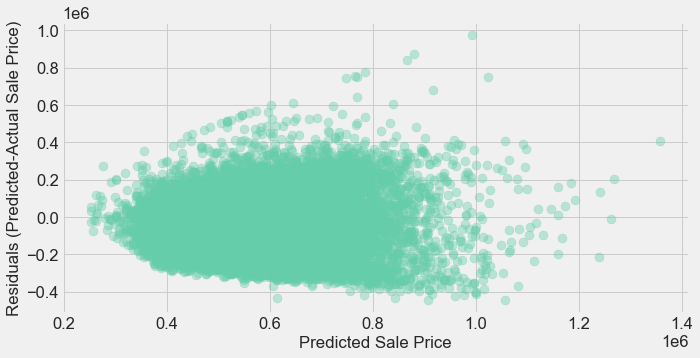

In [15]:
vz.error_plot(final, 'SalePrice', final_results)

In [16]:
fn.bp_test(final, 'SalePrice', final_results)

Lagrange Multiplier p-value: 0.0
F-statistic p-value: 0.0


#### Result: Fail.
Since our p-value is 0, we reject the null hypothesis and conclude that the variance of the target is not homogeneous across all values of the predictors. This agrees with the error plot above, but the residuals have shown a good deal of improvement over the baseline.

### Independence Check:  Variance Inflation Factor

In [17]:
fn.vif(final)

,VIF,feature
0,1.399061,SqFtOpenPorch
1,1.026556,SqFtEnclosedPorch
2,1.576362,SqFtDeck
3,1.710278,SqFtFinBasement
4,2.597505,SqFtTotLiving_sqrt
5,1.031041,x0_Floor_Wall
6,1.002706,x0_Gravity
7,1.094837,x0_Heat_Pump
8,1.023351,x0_Hot_Water
9,1.001952,x0_NA


#### Result: Pass
Since all the VIF values are less than five, we conclude the the model is free of multicollinearities.

### Bottom Line on the  Results of the Final Model
R-squared has increased slightly from .371 in the baseline model to .375. All p-values and CIs are valid except for the `Floor-Wall` and `SqFtEnclosedPorch` categories and the intercept looks good. The Jarque_Bera p-value is still small and heteroscadasticity is still present in the residuals, but the residuals look better than in the baseline model. While the condition number is still large, the VIF numbers for the features show no multicollinearity. The final model is an improvement over the baseline model.

# Regression Findings
The modeling process has uncovered a few overall trends in the data that can be used a basis for testing various client recommendations. All of the models have shown a positive correlation between the `SalePrice` target and `SqFtTotalLiving` predictor. Square-root scaling `SqFtTotLiving` provided the best improvement to model performance. The models have also shown that all other heating types have improved the `SalePrice` target relative to ElecBB heat. Lastly, the models have also shown that the `SqFtOpenPorch`, `SqFtEnclosedPorch`, and `SqFtFinBasement` features are all positively correlated with the target. Focusing on the heating system, porches, and basements makes sense for the project, because these are all features that can be changed or upgraded to increase the sale price of homes.

# Recommendations for Home Improvements

Given the information gleaned from the modeling process, the following three home improvement projects were found to correlate to higher home prices:
* Convert enclosed porches to open porches.
* Upgrade Electric Baseboard & Floor-Wall heating systems to alternate heating types.
* Upgrade basements up to a finished quality level of at least average.




#### Testing Data Frame
The t-tests for the recommendations were run on data with `SalePrice` and `PriceSqFt` outliers removed, but unfiltered by the residuals. All statistical tests performed during the project used a significance level of **alpha = .05**, and are detailed in the [EDA Notebook](../exploratory/final_notebook.ipynb).

In [18]:
data_path3 = os.path.join(gparent,'data/processed','clean.csv')
clean_df = pd.read_csv(data_path3)

# Porches
There were two categories of porches represented in the data: Open and Enclosed. Statistical tests were performed to see if there was a meaningful difference in the mean sale price of homes with strictly open porches compared to homes with strictly open porches. There were about 270 homes with both open and enclosed porches that were excluded from the tests.

### Recommendation:
#### Convert closed porches to open porches, and do not enclose any currently open porches.

#### The difference in average sale price between the two groups Is \$82,926.

In [19]:
po = fn.porches(clean_df)

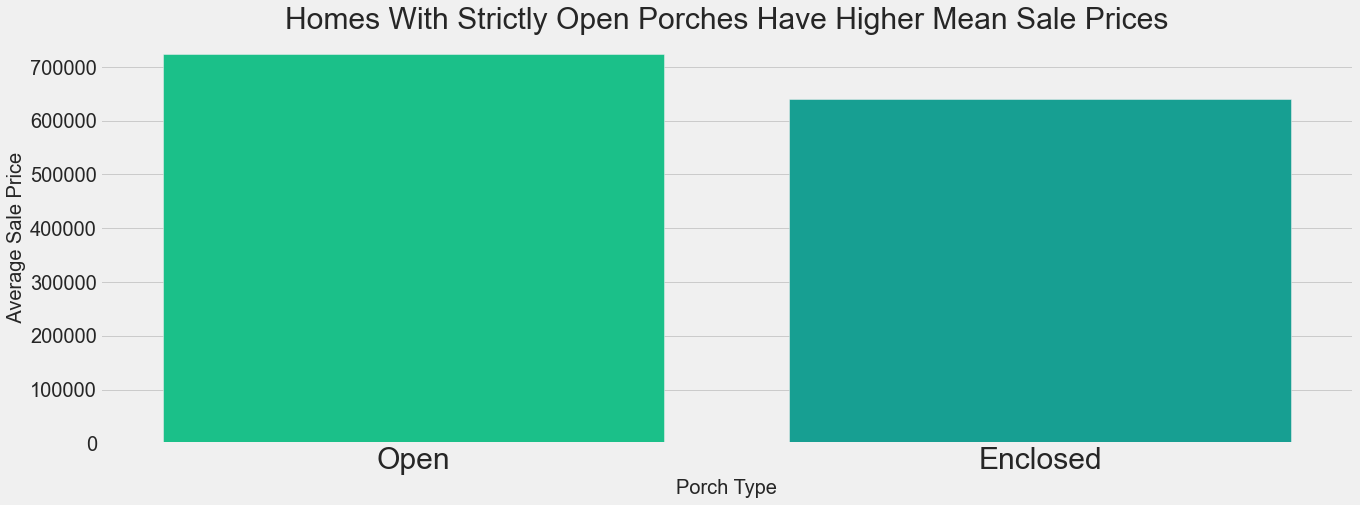

In [20]:
vz.strict_porches(po[0],po[1])

### t-Test: Strictly Open Porches vs Strictly Enclosed Porches
Homes with only open porches, or enclosed porches.

#### Null & Alternative Hypotheses
Ho: The average sale price of homes with strictly open porches is less than or equal to that of homes with strictly enclosed porches.

Ha: The average sale price of homes with strictly open porches is greater than that of homes with strictly enclosed porches. 

#### t-test p-value
p = 4.133146736231514e-09

#### Result: Reject the Null Hypothesis
Since the p-value is less than .05, we reject the null hypothesis and conclude that the average sale price of homes with strictly open porches is greater than that of homes with strictly open porches.

#### Effect Size: Cohen's d = .28
A Cohen's d value of .28 indicates a modest but non-trivial difference in the mean sales prices between the two groups.

### Porch Analysis Next Steps
Look into the set of mixed porches homes to see if the recommendation holds in those cases.

# Heating Systems

The following were various heating system types that were represented in the data: Floor-Wall, Gravity, Radiant, Elec BB, Forced Air, Hot Water, Heat Pump, and Other. Some homes also had no heat system available and were tagged 'NA'. Statistical tests were performed to see if there was a meaningful difference in the mean sale price of homes Electric Baseboard or Floor_Wall heating systems compared to homes with alternate heating systems.

## Recommendation:
#### Upgrade Electric Baseboard & Floor-Wall heating systems to alternate heating types.

#### The difference in average sale price is \$197,538.

In [21]:
h = fn.heat_sys(clean_df)

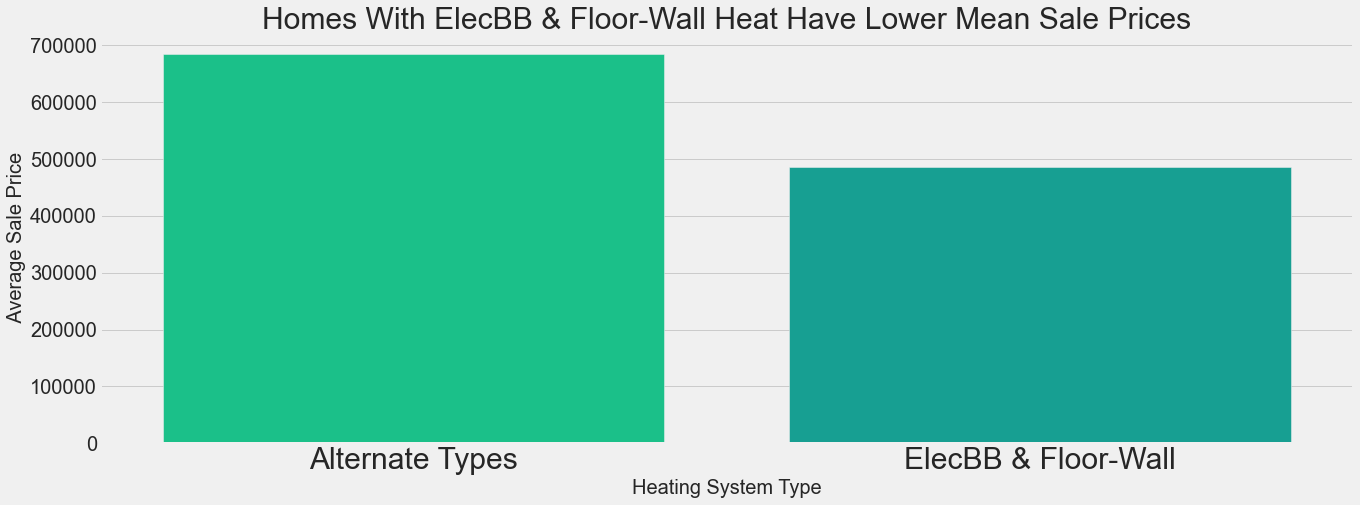

In [22]:
vz.elecbb(h[0],h[1])

### t-Test: ElecBB & Floor-Wall vs Alternate Heating Systems
The test finds that there is a statistically significant difference in mean sale price of homes with electic baseboard or floor-wall heating to the mean sale price of homes with alternate heating systems.

#### Null & Alternative Hypotheses
Ho: The average sale prices of homes with ElecBB or Floor-Wall heating are greater than or equal to those of homes with other forms of heating.

Ha: The average sale prices of homes with ElecBB or Floor-Wall heating are less than those of homes with other forms of heating.

#### t-test p-value
p=6.3394823248834e-216

#### Result: Reject the Null Hypothesis
Since the p-value is less than .05, we reject the null hypothesis and conclude that the average sale prices of homes with ElecBB or Floor-Wall heating are less than those of homes with other forms of heating.

#### Effect Size: Cohen's d = .72
A Cohen's d value of .72 indicates a significant difference in the mean sale price between the two groups.

#### Tukey Test Results
The results confirm that there are meaningful differences between the mean sale price of homes with the lower performing heating systems (Elec BB & Floor-Wall) and higher performing heating systems (excluding NA & Other). It did not find a meaningful difference between Elec BB and Floor-Wall. The recommendation is for ElecBB & Floor-wall systems to be upgraded.

### Heating Systems Next Steps
More exploration into the alternate heating systems to analyze the upgrade cost vs effect on sale price of homes between the different types of alternate heating systems.

# Basements
The data on finished basement quality was split into numeric categories arranged in ascending order. If a home had a finished basement quality rating of 0, it had an unfinished basement. Statstical tests were initially performed on finished basements compared to unfinished basements, and then between various grades of finished basements against each other.

## Recommendation:
#### Upgrade basements up to a finished quality level of at least average.
* The Difference in Average Sale Price Between Finished & Unfinished is \$112,250.
* The Difference in Average Sale Price Between Average and Poor Quality is \$197,879.

### Finished vs Unfinished

#### The difference in average sale price between finished & unfinished is \$112,250.

In [23]:
fb = fn.finished(clean_df)

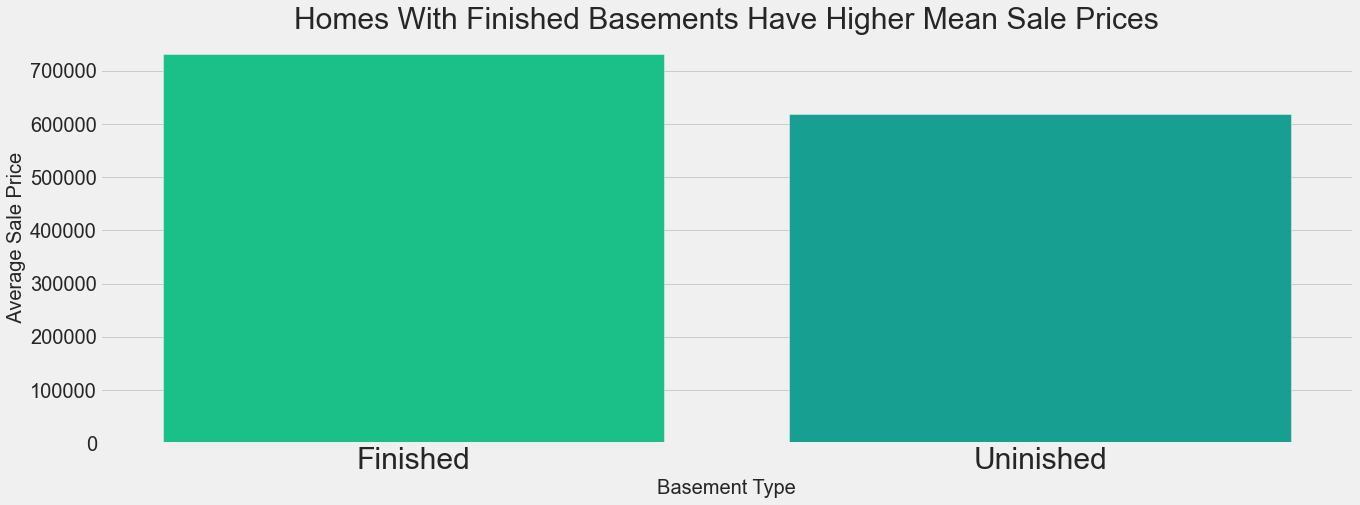

In [24]:
vz.finished(fb[0], fb[1])

### t-Test: Finished vs Unfinished Basements
The test finds that there is a statistically significant difference in mean sale price between homes with unfinished and finished basements.

#### Null & Alternative Hypotheses
Ho: The mean sale price of homes with finished basements is less than or equal to that of a homes with unfinished basements.

Ha: The mean sale price of homes with finished basements is higher than that of homes with unfinished basements.

#### t-test p-value
pvalue=5.314302329646943e-129

#### Result: Reject the Null Hypothesis
Since the p-value of the t-test is below alpha=.05, we reject the null hypothesis and conclude that homes with finished basements have a higher mean sale price than homes with unfinished basements.

#### Effect Size: Cohen's d = .41
A value of .41 indicates a moderate difference in the mean sale price between the two groups.

## Poor vs Fair Quality Basements
**The results indicate that there is no statistically significant difference in mean sale price between homes with poor quality basements and homes with fair quality quality basements. Upgrades should be to at least average quality.**

### t-Test: Poor vs Fair Quality Basements

#### Null & Alternative Hypotheses
Ho: The mean sale price of homes with fair quality basements is less than or equal to that of a homes with poor quality basements.

Ha: The mean sale price of homes with fair quality basements is higher than that of homes with poor quality basements.

#### t-test p-value
pvalue=0.07858450136299434

#### Result: Fail to Reject the Null Hypothesis
Since the p-value of the t-test is above alpha=.05, we fail to reject the null hypothesis and conclude that the mean sale price of homes with fair quality basements is less than or equal to that of a homes with poor quality basements.

## Average vs Poor Quality Basements

#### The difference in mean sale prices Average and Poor Quality is \$197,879.

In [25]:
ap = fn.ave_poor(clean_df)

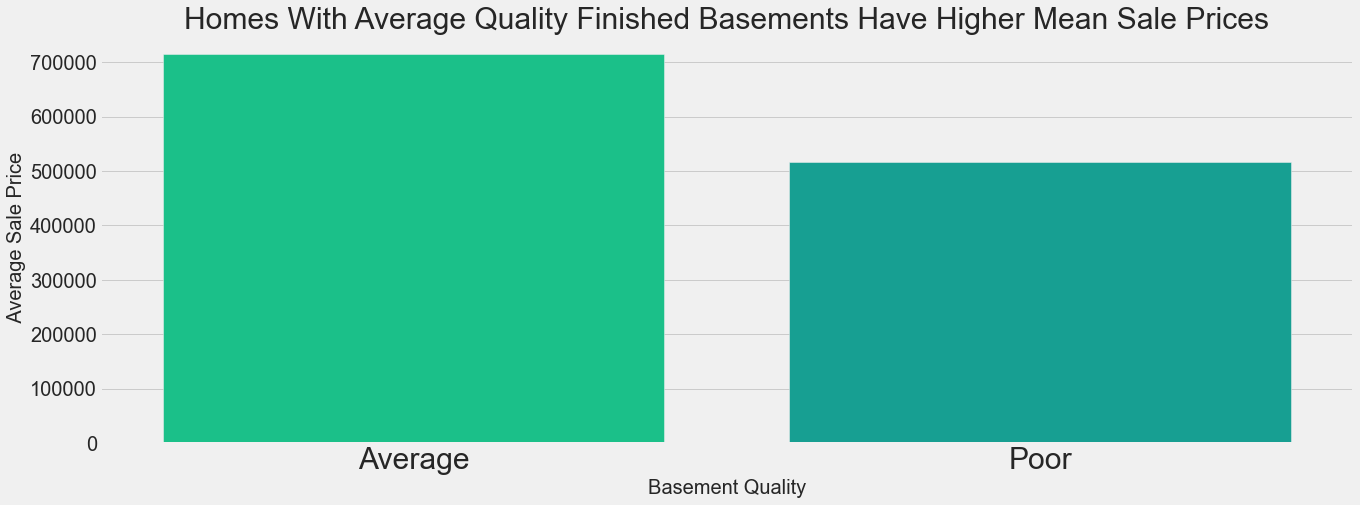

In [26]:
vz.po_ave(ap[0],ap[1])

### t-Test: Average vs Poor Quality Basements

#### Null & Alternative Hypotheses
Ho: The mean sale price of homes with average quality basements is less than or equal to that of a homes with poor quality basements.

Ha: The mean sale price of homes with higher quality basements is higher than that of homes with average quality basements.

#### t-test p-value
pvalue=0.01840475612778365

#### Result: Reject the Null Hypothesis
Since the p-value of the t-test is below alpha=.05, we reject the null hypothesis and conclude that the mean sale price of homes with higher quality basements is greater than that of a homes with average  quality basements.

#### Effect Size: Cohen's d = .73
Cohen's d value of 1.47 indicates a significant difference in mean sale price between the to groups.

### Basements Next Steps
Quanitify the characteristics that demarcate the various quality levels for finished basements.

# Recommendations & Next Steps Recap

## Recommendations Recap

* Convert enclosed porches to open porches, and do not enclose any currently open porches.
* Upgrade Electric Baseboard & Floor-Wall heating systems to alternate heating types.
* Upgrade basements up to a finished quality level of at least average.




## Modeling Next Steps
* More work on the filtered cluster of homes. Hopefully, some clarity can be gain on how they effect the model and steps can be taken to include them in the model, or quantify the effect of leaving them out. 
* The final model is missing the `Forced Air` heating type. Moving forward, a next step in the process is to find a way to add it back in to the model without breaking the independence assuption of linear regression.
* Adding more features to help improve the coefficient determination.

## Recommendations Next Steps

* Look into the set of mixed porches homes to see if the recommendation holds in those cases.
* More exploration into the alternate heating systems to analyze the upgrade cost vs effect on sale price of homes between the different types of alternate heating systems.
* Quanitify the characteristics that demarcate the various quality levels for finished basements.